# Simulate Trading Bot Action

## Download historical data

### Prepare date range

In [9]:
from datetime import datetime, timedelta

N_DAYS = 100

end = datetime.today().date()
start = end - timedelta(days=N_DAYS)
start

datetime.date(2024, 2, 29)

### Prepare client

In [10]:
import os

API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")

In [11]:
from alpaca.data.historical import CryptoHistoricalDataClient
client_data = CryptoHistoricalDataClient(API_KEY, API_SECRET)

### Prepare data request

In [14]:
from alpaca.data import requests
from alpaca.data.timeframe import TimeFrame

symbol = 'BTC/USD'

request = requests.CryptoBarsRequest(
    symbol_or_symbols=symbol,
    start=start,
    end=end, 
    limit=100,
    timeframe=TimeFrame.Day
)

### Get data

In [16]:
response = client_data.get_crypto_bars(request)
df = response.df
df

open        high        low  \
symbol  timestamp                                                      
BTC/USD 2024-02-29 06:00:00+00:00  62504.9235  63654.5755  60390.816   
        2024-03-01 06:00:00+00:00  61295.6110  63110.2535  61219.930   
...                                       ...         ...        ...   
        2024-06-06 05:00:00+00:00  71059.9955  71622.4980  70125.820   
        2024-06-07 05:00:00+00:00  71268.8700  71924.6460  68723.705   

                                        close    volume  trade_count  \
symbol  timestamp                                                      
BTC/USD 2024-02-29 06:00:00+00:00  61335.7055  6.677049        510.0   
        2024-03-01 06:00:00+00:00  62079.7935  6.626801        221.0   
...                                       ...       ...          ...   
        2024-06-06 05:00:00+00:00  71202.7300  1.823753         76.0   
        2024-06-07 05:00:00+00:00  69313.2100  1.152860         83.0   

                                           vwap  
symbol  timestamp                                
BTC/USD 2024-02-29 06:00:00+00:00  62004.015570  
        2024-03-01 06:00:00+00:00  61998.490120  
...                                         ...  
        2024-06-06 05:00:00+00:00  71242.655428  
        2024-06-07 05:00:00+00:00  70516.503422  

[100 rows x 7 columns]

## Bollinger Strategy

### Calculate bands

In [20]:
df_bollinger = df.loc[symbol, 'close'].to_frame()

K = 2
N_WINDOWS = 30

rolling_std = df_bollinger.close.rolling(N_WINDOWS).std()
rolling_mean = df_bollinger.close.rolling(N_WINDOWS).mean()

df_bollinger = (df_bollinger
 .assign(
     upper = rolling_mean + rolling_std * K,
     lower = rolling_mean - rolling_std * K)
)

df_bollinger

,close,upper,lower
timestamp,,,
2024-02-29 06:00:00+00:00,61335.7055,NaN,NaN
2024-03-01 06:00:00+00:00,62079.7935,NaN,NaN
...,...,...,...
2024-06-06 05:00:00+00:00,71202.7300,73501.029016,60359.970351
2024-06-07 05:00:00+00:00,69313.2100,73483.645996,60898.725037


### Visualize data

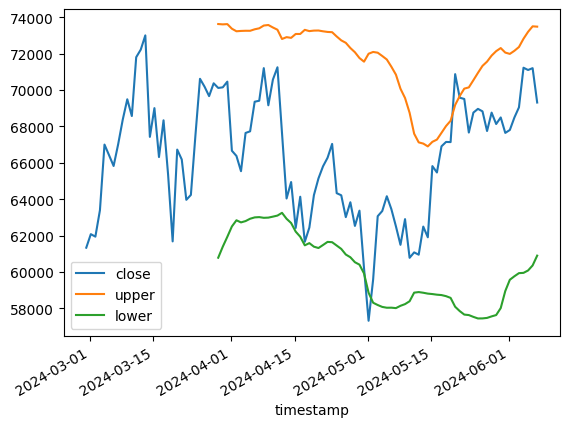

In [21]:
df_bollinger.plot();

## Prepare orders

### Prepare Alpaca Trading API

In [22]:
from alpaca.trading.client import TradingClient
client_trading = TradingClient(API_KEY, API_SECRET, paper=True)

### Configure market order request

In [23]:
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

symbol = 'BTCUSD'

request_order = MarketOrderRequest(
    symbol=symbol,
    qty=0.1,
    side=OrderSide.BUY,
    time_in_force=TimeInForce.GTC)

request_order

{   'client_order_id': None,
    'extended_hours': None,
    'notional': None,
    'order_class': None,
    'position_intent': None,
    'qty': 0.1,
    'side': <OrderSide.BUY: 'buy'>,
    'stop_loss': None,
    'symbol': 'BTCUSD',
    'take_profit': None,
    'time_in_force': <TimeInForce.GTC: 'gtc'>,
    'type': <OrderType.MARKET: 'market'>}

```python
# Order to Buy and Open Position
request = client_trading.submit_order(order_data=request_order)

# close position
request = client_trading.close_position(symbol)
```

## Execute the order

### Get last price

In [24]:
last_day = df_bollinger.iloc[-1]
last_day

close    69313.210000
upper    73483.645996
lower    60898.725037
Name: 2024-06-07 05:00:00+00:00, dtype: float64

In [25]:
close, upper, lower = last_day

### Open position?

In [26]:
try:
    client_trading.get_open_position(symbol)
    flag_bought = True
except Exception as e:
    flag_bought = False
    print(e)

### Conditionals with signals

In [27]:
if (lower > close) and  (not flag_bought):
    request = client_trading.submit_order(order_data=request_order)
elif (close > upper) and (flag_bought):
    request = client_trading.close_position(symbol)
else:
    request = 'No trade executed.'
    
request

'No trade executed.'